In [1]:
from __future__ import division, print_function, unicode_literals

In [2]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

In [3]:
# reset default graph in case the notebook is rerun without restarting the kernel
tf.reset_default_graph()

In [4]:
np.random.seed(42)
tf.set_random_seed(42)

In [5]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('C:/Users/Aman Deep Singh/Documents/Python/Data/MNIST/data/')

Extracting C:/Users/Aman Deep Singh/Documents/Python/Data/MNIST/data/train-images-idx3-ubyte.gz
Extracting C:/Users/Aman Deep Singh/Documents/Python/Data/MNIST/data/train-labels-idx1-ubyte.gz
Extracting C:/Users/Aman Deep Singh/Documents/Python/Data/MNIST/data/t10k-images-idx3-ubyte.gz
Extracting C:/Users/Aman Deep Singh/Documents/Python/Data/MNIST/data/t10k-labels-idx1-ubyte.gz


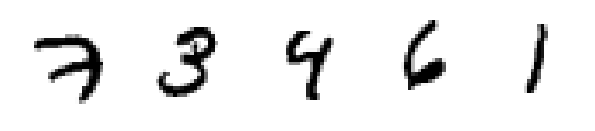

In [6]:
n_samples = 5

plt.figure(figsize=(n_samples * 2, 3))
for index in range(n_samples):
    plt.subplot(1, n_samples, index + 1)
    sample_image = mnist.train.images[index].reshape(28, 28)
    plt.imshow(sample_image, cmap='binary')
    plt.axis('off')

plt.show()

In [7]:
mnist.train.labels[:n_samples]

array([7, 3, 4, 6, 1], dtype=uint8)

In [8]:
# Input images
X = tf.placeholder(shape=[None, 28, 28, 1], dtype=tf.float32, name='X')

In [9]:
# primary capsules
# 32 maps of 6x6 capsules each
# each capsule has an 8D activation vector
caps1_n_maps = 32
caps1_n_caps = caps1_n_maps * 6 * 6
caps1_n_dims = 8

In [10]:
conv1_params = {
    'filters': 256,
    'kernel_size': 9,
    'strides': 1,
    'padding': 'valid',
    'activation': tf.nn.relu
}

conv2_params = {
    'filters': caps1_n_maps * caps1_n_dims, # 256 convolutional filters
    'kernel_size': 9,
    'strides': 2,
    'padding': 'valid',
    'activation': tf.nn.relu
}

In [11]:
conv1 = tf.layers.conv2d(X, name='conv1', **conv1_params)
conv2 = tf.layers.conv2d(conv1, name='conv2', **conv2_params)

In [12]:
caps1_raw = tf.reshape(conv2, [-1, caps1_n_caps, caps1_n_dims], name='caps1_raw')

$\operatorname{squash}(\mathbf{s}) = \dfrac{\|\mathbf{s}\|^2}{1 + \|\mathbf{s}\|^2} \dfrac{\mathbf{s}}{\|\mathbf{s}\|}$

In [13]:
def squash(s, axis=-1, epsilon=1e-7, name=None):
    with tf.name_scope(name, default_name='squash'):
        squared_norm = tf.reduce_sum(tf.square(s), axis=axis, keep_dims=True)
        safe_norm = tf.sqrt(squared_norm + epsilon)
        squash_factor = squared_norm / (1. + squared_norm)
        unit_vector = s / safe_norm
        return squash_factor * unit_vector

In [14]:
caps1_output = squash(caps1_raw, name='caps1_output')

In [15]:
# digit capsules
caps2_n_caps = 10
caps2_n_dims = 16

In [16]:
init_sigma = 0.01

W_init = tf.random_normal(
    shape=(1, caps1_n_caps, caps2_n_caps, caps2_n_dims, caps1_n_dims),
    stddev=init_sigma, dtype=tf.float32, name='W_init')
W = tf.Variable(W_init, name='W')

In [17]:
batch_size = tf.shape(X)[0]
W_tiled = tf.tile(W, [batch_size, 1, 1, 1, 1], name='W_tiled')

In [18]:
caps1_output_expanded = tf.expand_dims(caps1_output, -1, name='caps1_output_expanded')
caps1_output_tile = tf.expand_dims(caps1_output_expanded, 2, name='caps1_output_tile')
caps1_output_tiled = tf.tile(caps1_output_tile, [1, 1, caps2_n_caps, 1, 1], name='caps1_output_tiled')

In [19]:
W_tiled

<tf.Tensor 'W_tiled:0' shape=(?, 1152, 10, 16, 8) dtype=float32>

In [20]:
caps1_output_tiled

<tf.Tensor 'caps1_output_tiled:0' shape=(?, 1152, 10, 8, 1) dtype=float32>

In [21]:
caps2_predicted = tf.matmul(W_tiled, caps1_output_tiled, name='caps2_predicted')

In [22]:
caps2_predicted

<tf.Tensor 'caps2_predicted:0' shape=(?, 1152, 10, 16, 1) dtype=float32>

In [23]:
# Routing by agreement
raw_weights = tf.zeros([batch_size, caps1_n_caps, caps2_n_caps, 1, 1], dtype=np.float32, name='raw_weights')

In [24]:
routing_weights = tf.nn.softmax(raw_weights, dim=2, name='routing_weights')

In [25]:
weighted_predictions = tf.multiply(routing_weights, caps2_predicted, name='weighted_predictions')
weighted_sum = tf.reduce_sum(weighted_predictions, axis=1, keep_dims=True, name='weighted_sum')

In [26]:
caps2_output_round_1 = squash(weighted_sum, axis=-2, name='caps2_output_round_1')

In [27]:
caps2_output_round_1

<tf.Tensor 'caps2_output_round_1/mul:0' shape=(?, 1, 10, 16, 1) dtype=float32>

In [28]:
# Round 2
caps2_predicted

<tf.Tensor 'caps2_predicted:0' shape=(?, 1152, 10, 16, 1) dtype=float32>

In [29]:
caps2_output_round_1

<tf.Tensor 'caps2_output_round_1/mul:0' shape=(?, 1, 10, 16, 1) dtype=float32>

In [30]:
caps2_output_round_1_tiled = tf.tile(
    caps2_output_round_1, [1, caps1_n_caps, 1, 1, 1],
    name='caps2_output_round_1_tiled')

In [31]:
agreement = tf.matmul(caps2_predicted, caps2_output_round_1_tiled, transpose_a=True, name='agreement')

In [32]:
raw_weights_round_2 = tf.add(raw_weights, agreement, name='raw_weights_round_2')

In [33]:
routing_weights_round_2 = tf.nn.softmax(raw_weights_round_2, dim=2, name='routing_weights_round_2')
weighted_predictions_round_2 = tf.multiply(routing_weights_round_2, caps2_predicted, name='weighted_predictions_round_2')
weighted_sum_round_2 = tf.reduce_sum(weighted_predictions_round_2, axis=1, keep_dims=True, name='weighted_sum_round_2')
caps2_output_round_2 = squash(weighted_sum_round_2, axis=-2, name='caps2_output_round_2')

In [34]:
caps2_output = caps2_output_round_2

In [35]:
# dynamic tensorflow loop
def condition(input, counter):
    return tf.less(counter, 100)

def loop_body(input, counter):
    output = tf.add(input, tf.square(counter))
    return output, tf.add(counter, 1)

with tf.name_scope('compute_sum_of_squares'):
    counter = tf.constant(1)
    sum_of_squares = tf.constant(0)
    result = tf.while_loop(condition, loop_body, [sum_of_squares, counter])

with tf.Session() as sess:
    print(sess.run(result))

(328350, 100)


In [36]:
# alternative: sum([i**2 for i in range(1, 101)])
# but this increases the size of the tensorflow graph, and hence, using a dynamic loop is advisable

In [37]:
def safe_norm(s,  axis=-1, epsilon=1e-7, keep_dims=False, name=None):
    with tf.name_scope(name, default_name='safe_norm'):
        squared_norm = tf.reduce_sum(tf.square(s), axis=axis, keep_dims=keep_dims)
        return tf.sqrt(squared_norm + epsilon)

In [38]:
y_proba = safe_norm(caps2_output, axis=-2, name='y_proba')

In [39]:
y_proba_argmax = tf.argmax(y_proba, axis=2, name='y_proba')

In [40]:
y_proba_argmax

<tf.Tensor 'y_proba_1:0' shape=(?, 1, 1) dtype=int64>

In [41]:
y_pred = tf.squeeze(y_proba_argmax, axis=[1, 2], name='y_pred')

In [42]:
y_pred

<tf.Tensor 'y_pred:0' shape=(?,) dtype=int64>

In [43]:
# labels
y = tf.placeholder(shape=[None], dtype=tf.int64, name='y')

In [44]:
m_plus = 0.9
m_minus = 0.1
lambda_ = 0.5

In [45]:
T = tf.one_hot(y, depth=caps2_n_caps, name='T')

In [46]:
# example
with tf.Session():
    print(T.eval(feed_dict={y: np.array([0, 1, 2, 3, 9])}))

[[ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  1.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  1.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  1.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  1.]]


In [47]:
caps2_output

<tf.Tensor 'caps2_output_round_2/mul:0' shape=(?, 1, 10, 16, 1) dtype=float32>

In [48]:
caps2_output_norm = safe_norm(caps2_output, axis=-2, keep_dims=True, name='caps2_output_norm')

In [49]:
present_error_raw = tf.square(tf.maximum(0., m_plus - caps2_output_norm), name='present_error_raw')
present_error = tf.reshape(present_error_raw, shape=(-1, 10), name='present_error')

In [50]:
absent_error_raw = tf.square(tf.maximum(0., caps2_output_norm - m_minus), name='absent_error_raw')
absent_error = tf.reshape(absent_error_raw, shape=(-1, 10), name='absent_error')

In [51]:
L = tf.add(T * present_error, lambda_ * (1.0 - T) * absent_error, name='L')

In [52]:
margin_loss = tf.reduce_mean(tf.reduce_sum(L, axis=1), name='margin_loss')

In [53]:
# reconstruction
# mask
mask_with_labels = tf.placeholder_with_default(False, shape=(), name='mask_with_labels')

In [54]:
reconstruction_targets = tf.cond(mask_with_labels, lambda: y, lambda: y_pred, name='reconstruction_targets')

In [55]:
reconstruction_mask = tf.one_hot(reconstruction_targets, depth=caps2_n_caps, name='reconstruction_mask')

In [56]:
reconstruction_mask

<tf.Tensor 'reconstruction_mask:0' shape=(?, 10) dtype=float32>

In [57]:
caps2_output

<tf.Tensor 'caps2_output_round_2/mul:0' shape=(?, 1, 10, 16, 1) dtype=float32>

In [58]:
reconstruction_mask_reshaped = tf.reshape(reconstruction_mask, [-1, 1, caps2_n_caps, 1, 1], name='reconstruction_mask_reshaped')

In [59]:
caps2_output_masked = tf.multiply(caps2_output, reconstruction_mask_reshaped, name='caps2_output_masked')

In [60]:
caps2_output_masked

<tf.Tensor 'caps2_output_masked:0' shape=(?, 1, 10, 16, 1) dtype=float32>

In [61]:
decoder_input = tf.reshape(caps2_output_masked, [-1, caps2_n_caps * caps2_n_dims], name='decoder_input')

In [62]:
decoder_input

<tf.Tensor 'decoder_input:0' shape=(?, 160) dtype=float32>

In [63]:
# decoder
n_hidden1 = 512
n_hidden2 = 1024
n_output = 28 * 28

In [67]:
with tf.name_scope('decoder'):
    decoder_hidden1 = tf.layers.dense(decoder_input, n_hidden1, activation=tf.nn.relu, name='decoder_hidden1')
    decoder_hidden2 = tf.layers.dense(decoder_hidden1, n_hidden2, activation=tf.nn.relu, name='decoder_hidden2')
    decoder_output = tf.layers.dense(decoder_hidden2, n_output, activation=tf.nn.sigmoid, name='decoder_output')

In [68]:
# reconstruction loss
X_flat = tf.reshape(X, [-1, n_output], name='X_flat')
squared_difference = tf.square(X_flat - decoder_output, name='squared_difference')
reconstruction_loss = tf.reduce_mean(squared_difference, name='reconstruction_loss')